# Семинар 4. Policy Gradients

In [65]:
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

## Policy Gradients
Мы будем обучать агента без явного отображения значения для каждой пары состояние-действие в среде. Будем обновлять политику на основе вознаграждения, связанного с каждым шагом. Агент может получить награду сразу за действие, или агент может получить награду позже, например, в конце эпизода.
Мы применим метод под названием «Градиент политики Монте-Карло», который означает, что агент будет проходить весь эпизод, а затем обновлять нашу политику в зависимости от полученных наград.

In [66]:
#Hyperparameters
learning_rate = 0.01
G = 0.99
seed = 543
render = True
log_interval = 10

In [67]:
env = gym.make('CartPole-v1')
env.seed(seed)
torch.manual_seed(seed)

## Соберем нейронную сеть для апроксимации политики

In [68]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        # Соберем свою нейронку
        

    def forward(self, x):
        


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
eps = np.finfo(np.float32).eps.item()

## Select Action
Функция select_action выбирает действие на основе распределения вероятностей нашей политики. Наша политика возвращает вероятность для каждого возможного действия в нашем пространстве действий (движение влево или вправо) в виде массива длиной два, например [0,7, 0,3]. Затем мы выбираем действие на основе этих вероятностей, записываем историю действий и возвращаем действие актора.

In [69]:
def select_action(state):
    # Читаем состояние
    
    
    # Предсказываем вероятности
    
    # Выбираем действие на основе вероятностей (например e-greedy)
    
    return action.item()

## Обновление политики
Мы обновляем нашу политику играя эпизоды. Выигрыш определяется как ожидаемый доход от выполнения действия $ a $ в состоянии $ s $ в соответствии с политикой $ \pi $.

Мы знаем, что за каждый шаг продолжения симуляции мы получаем вознаграждение в размере 1. Мы можем использовать это для вычисления градиента политики на каждом временном шаге, где $ r $ - это вознаграждение для конкретной пары состояние-действие. Вместо мгновенного вознаграждения $ r $ мы используем долгосрочное вознаграждение $ v_{t} $, где $ v_{t} $ - это дисконтированная сумма всех будущих вознаграждений на протяжении всего эпизода. Таким образом, чем "дольше" эпизод длится, тем "больше" награда за конкретную пару состояние-действие в настоящем. $ v_{t} $ тогда,

$$ v_{t} = \sum_{k=0}^{N} \gamma^{k}r_{t+k} $$

где $ \gamma $ - коэффициент дисконтирования (0,99). Например, если эпизод длится 5 шагов, награда за каждый шаг будет [4,90, 3,94, 2,97, 1,99, 1].
Затем мы масштабируем наш вектор вознаграждения, вычитая среднее значение из каждого элемента и масштабируя до единичной дисперсии путем деления на стандартное отклонение (нормировка).

Затем мы передадим нашу историю политик, умноженную на наши вознаграждения, нашему оптимизатору и обновим веса нашей нейронной сети, используя стохастический градиентный спуск. Это должно увеличить вероятность действий, которые принесли нашему агенту более крупное вознаграждение.



In [70]:
def update_policy():
    R = 0
    policy_loss = []
    returns = []
    
    # Дисконтируем (уменьшаем) награды для каждого шага
    for r in policy.rewards[::-1]:
        
        
    # Нормируем награду    
    
    
    # Считаем "ошибку"
    for log_prob, R in zip(policy.saved_log_probs, returns):
        
    
    # Обновляем веса сети
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]

## Training
Наш основной цикл обучения политике. Для каждого шага в эпизоде мы выбираем действие, делаем шаг по среде и записываем полученное новое состояние и награду. Мы вызываем update_policy() в конце каждого эпизода, чтобы передать историю эпизодов в нашу нейронную сеть и улучшить нашу политику.

In [71]:
def main(episodes):
    running_reward = 10
    reward_history = []
    
    # Цикл по эпизодам
    for i_episode in range(episodes):
        state = env.reset()
        ep_reward = 0
        
        # Цикл по одному эпизоду
        # Ограничивае число итераций для обучения
        for t in range(1, 10000):
            

        reward_history.append(ep_reward)
        
        # Обновляем среднюю награду
        
        
        # Обновляем политику
        
        if i_episode % log_interval == 0:
            print('Episode {}\tПоследняя награда: {:.2f}\tСредняя награда: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break
    return reward_history

## Run Model

In [73]:
episodes = 50
reward_history = main(episodes)

Episode 0	Последняя награда: 29.00	Средняя награда: 10.95
Episode 10	Последняя награда: 12.00	Средняя награда: 19.94
Episode 20	Последняя награда: 28.00	Средняя награда: 33.05
Episode 30	Последняя награда: 110.00	Средняя награда: 39.82
Episode 40	Последняя награда: 192.00	Средняя награда: 68.08


In [50]:
env.spec.reward_threshold

475.0

In [76]:
env.reset()
env.close()

## Plot Results

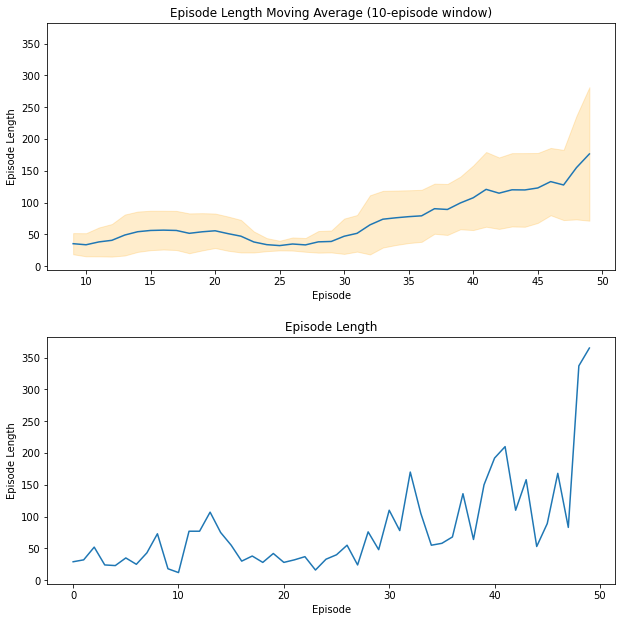

In [74]:
window = int(episodes/5)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(reward_history).rolling(window).mean()
std = pd.Series(reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')
